




# Projet Fil Rouge 2023 : Reconnaissance de commandes audio


**Noms :**

**Prénoms :**

**Nom du binôme :**




Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="files/DroneJS.JPG" width="600" height="500"  >



Ces séances se décomposent en ces parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re



# Preprocessing

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 


In [2]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')


The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [3]:
def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [4]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


### Spectral representation

1. Apply a Fourier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.

2. Let $\hat{X}$ be the Fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

In [5]:
from scipy import signal
from scipy.fft import fft

1000188


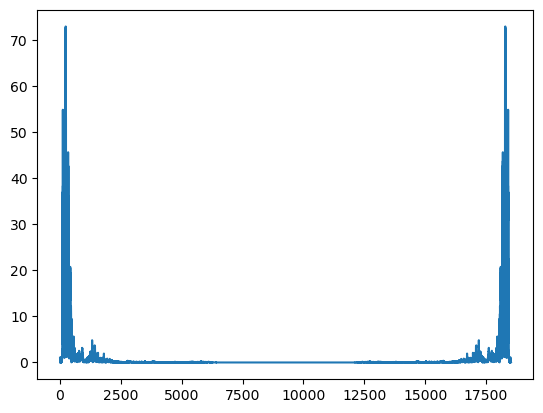

In [6]:
X_fourier = np.abs(fft(X))
print(np.size(X))
plt.plot(X_fourier[0])

1) Réponse: Une transformée de Fourier ne réduit pas les dimensions, si $X$ est un vecteur de dimension d alors $\hat{X}$ est de dimension d également

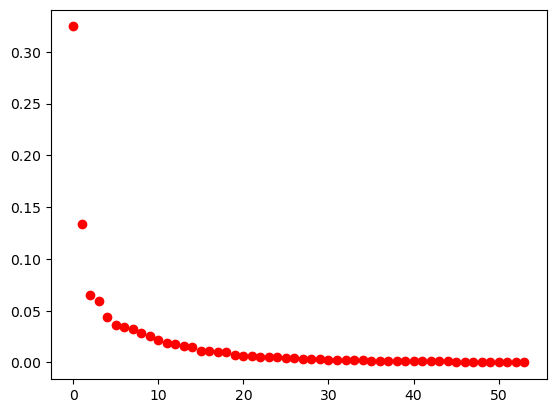

In [7]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X_fourier)
plt.plot(pca.explained_variance_ratio_, 'ro')#dimensions explicatives en %

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$?

4. Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female 

(127, 147)


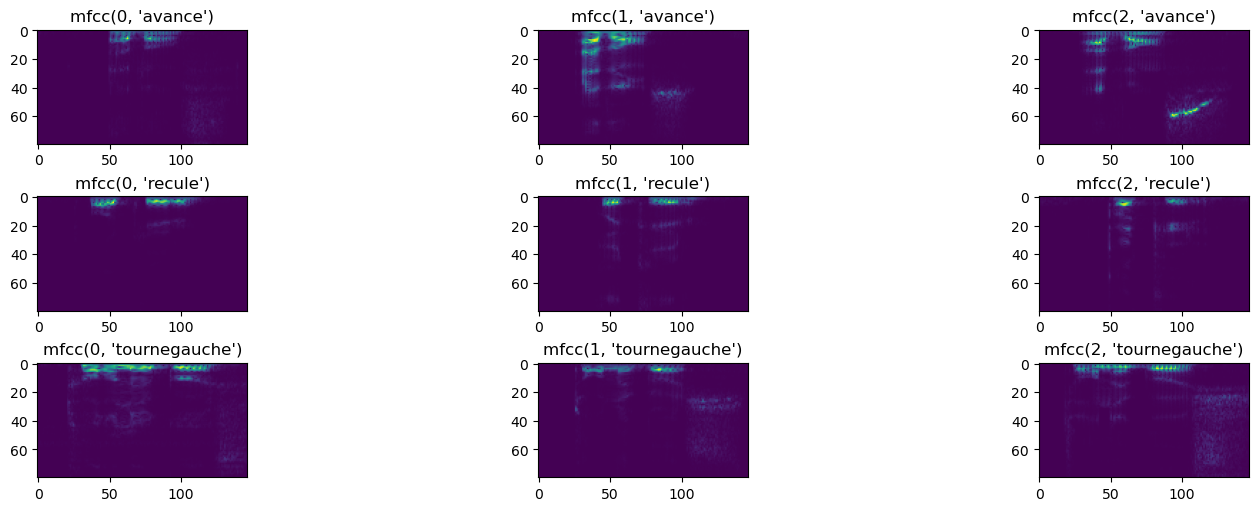

In [8]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxx.shape)
plt.show()

#### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT. 
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time. Add a second argument that gives the maximum frequency index

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation        
        return np.absolute(fft(X)[:self.idx_frequence_max])

In [11]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, stats='max', idx_frequency_max=80):
        self.stats = stats
        self.idx_frequency_max = idx_frequency_max
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        _, _, Zxx = signal.stft(X)
        if self.idx_frequency_max is not None:
            Zxx_tronque = Zxx[:,:,:self.idx_frequency_max]
        else:
            Zxx_tronque = Zxx
            
        if self.stats == 'moyenne':
            return np.mean(np.abs(Zxx_tronque), axis=1) #moyenne sur le temps
        elif self.stats == 'quantile':
            return np.percentile(np.abs(Zxx_tronque), 75, axis=1)
        elif self.stats == 'max':
            return np.max(np.abs(Zxx_tronque), axis=1)
        else:
            raise ValueError("erreur stats")


In [12]:
pstft = STFT(idx_frequency_max=80)
Z = pstft.transform(X)
print(np.shape(Z))
X_processed = pstft.transform(X)

(54, 80)


# Partie I : Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_compenents")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



Q.0) (Sans pipeline) : Choisir un preprocessing. Cocher une cross validation pour la régression logistique.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Evaluation of results

Evaluate the result by confusion matrix and percentage of correct classification.

*Tip:* Remember to put a function to display the confusion matrix

In [14]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [15]:
# # Sans transformation
# import random
# lengthX = len(X)
# ind = [i for i in range(lengthX)]
# scores = []

# random.shuffle(ind)
# model = LogisticRegression()

# for i in range(3):

#     ind_test_start = int(lengthX * 1/3 * i)
#     ind_test_end = int(lengthX * 1/3 * (i + 1))
#     ind_test = ind[ind_test_start:ind_test_end]

#     ind_train = [index for index in ind if index not in ind_test]

#     X_test, y_test = X[ind_test,:], y[ind_test]
#     X_train, y_train = X[ind_train,:], y[ind_train]

    
#     model.fit(X_train,y_train)
#     score = model.score(X_test,y_test)
#     scores.append(score)
# print(np.mean(scores))

In [16]:
# Avec ACP Sans LOO
import random
import sklearn.decomposition

lengthX = len(X)
ind = [i for i in range(lengthX)]

X_pca = sklearn.decomposition.PCA(n_components=15)
X_pca.fit(X_fourier)
X_acp = X_pca.transform(X_fourier)

random.shuffle(ind)
scores = []
model = LogisticRegression(C = 1000, max_iter = 1000)


for i in range(3):

    ind_test_start = int(lengthX * 1/3) * i
    ind_test_end = int(lengthX * 1/3) * (i + 1)
    ind_test = ind[ind_test_start:ind_test_end]

    ind_train = [index for index in ind if index not in ind_test]
    
    X_test, y_test = X_acp[ind_test,:], y[ind_test]
    X_train, y_train = X_acp[ind_train,:], y[ind_train]

    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    scores.append(score)

print(np.mean(scores))

0.6296296296296297


In [17]:
# Avec STFT sans LOO
import random
pstft = STFT(idx_frequency_max=80, stats="max")
X_transform = pstft.transform(X)
lengthX = len(X)
ind = [i for i in range(lengthX)]

random.shuffle(ind)
scores = []
scores_train=[]
model = LogisticRegression(C = 400, max_iter = 1000)

for i in range(3):

    ind_test_start = int(lengthX * 1/3 * i)
    ind_test_end = int(lengthX * 1/3 * (i + 1))
    ind_test = ind[ind_test_start:ind_test_end]

    ind_train = [index for index in ind if index not in ind_test]

    X_test, y_test = X_transform[ind_test,:], y[ind_test]
    X_train, y_train = X_transform[ind_train,:], y[ind_train]

    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    scores.append(score)
    score_train = model.score(X_train,y_train)
    scores_train.append(score_train)

print(np.mean(scores))
print(np.mean(scores_train))

0.5925925925925927
0.8333333333333334


In [18]:
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fft', FFT()),
                 ('pca', PCA()), 
                 ('model', LogisticRegression())])

param_gridsearch = {
    'scaler': [None, StandardScaler()],
    'pca__n_components': [12],
    'model__C':[500],
    'model__max_iter': [10000]
    }

loo = LeaveOneOut()

grid_search = GridSearchCV(pipe, param_gridsearch, cv=loo, scoring='accuracy')

# Perform GridSearchCV
grid_search.fit(X, y)




# pipestft = Pipeline([('scaler', StandardScaler()),
#                  ('fft', STFT()),
#                  ('model', LogisticRegression())])

# param_gridsearchstft = {
#     'stft__stats':['max'],
#     'stft__idx_frequency_max':[80],
#     'scaler': [None, StandardScaler()],
#     'model__C':[500],
#     'model__max_iter': [10000]
#     }

# loo = LeaveOneOut()

# grid_searchstft = GridSearchCV(pipestft, param_gridsearchstft, cv=loo, scoring='accuracy')

# # Perform GridSearchCV
# grid_searchstft.fit(X, y)

# # Print results
# print("Best parameters found:")
# print(grid_searchstft.best_params_)
# print("Best mean accuracy found:")
# print(grid_searchstft.best_score_)

# Print results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean accuracy found:")
print(grid_search.best_score_)

/home/n7student/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/n7student/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters found:
{'model__C': 500, 'model__max_iter': 10000, 'pca__n_components': 12, 'scaler': StandardScaler()}
Best mean accuracy found:
0.8518518518518519


# Part II: Classification by kernel methods

**Reminder** Kernel methods consist of plunging the data into a space of Hilbert dimension $\mathcal{H}$ where the data can be separated linearly.

**Representation Theorem:** The solution of the infinite dimensional separation problem is contained in a finite dimensional vector subspace of $\mathcal{H}$

### 1. Perform a core SVM classification

    1) Vary the core
    2) Vary the regularization parameter.

1. SVM lin 
2. SVM kernel gaussian try different gamma & try different C
3. SVM kernel au choix try different parameters

#### 1,2,3 with cross-validation to chose hyperparameters + gridsearchCV

4. Draw the classification border in the 2 first components of a PCA

In [16]:
from sklearn.svm import SVC

In [20]:

pipe = Pipeline([('scaler', StandardScaler()),
                 ('fft', STFT()),
                 ('model', SVC())])

param_gridsearch = {
    'scaler': [None, StandardScaler()],
    'model__C':[100,300,600,900,1200],
    'model__max_iter': [1000],
    'model__kernel':['linear','poly','rbf'],
    'model__gamma':['auto'],
    'model__degree':[2,3,5]
    }

loo = LeaveOneOut()

grid_search = GridSearchCV(pipe, param_gridsearch, cv=loo, scoring='accuracy')

# Perform GridSearchCV
grid_search.fit(X, y)

# Print results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean accuracy found:")
print(grid_search.best_score_)

Best parameters found:
{'model__C': 300, 'model__degree': 2, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'model__max_iter': 1000, 'scaler': StandardScaler()}
Best mean accuracy found:
0.6666666666666666


# Part III: Ensemble Method

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.

1. First you will transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification

2. Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)

3. Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [49]:
# 1. create y1
y1 = []
for i in range(len(y)):
    if y[i] == 1:
        y1.append(1)
    elif y[i] == 2 or y[i] == 0:
        y1.append(0)

y1 = np.array(y1)

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

np.random.seed(28)

M = 100
max_depth = 2
models = []

X_train, X_test, y_train, y_test = train_test_split(X_processed,y1,test_size=0.4, random_state=42)

# Train M decision trees
for _ in range(M):
    # Bootstrap
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrap = X_train[indices]
    y_bootstrap = y_train[indices]
    
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_bootstrap, y_bootstrap)
    
    models.append(model)

# Make predictions on the test set and calculate the accuracy
def bagging_predict(models, X):
    predictions = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X)
    return (predictions.mean(axis=1) >= 0.5).astype(int)

# Calculate accuracy of bagging model
y_pred_bagging = bagging_predict(models, X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print("Accuracy of Bagging Model:", accuracy_bagging)

# Calculate mean accuracy of individual models
accuracies = [] 
for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

mean_accuracy = np.mean(accuracies)
print("Mean Accuracy of Individual Models:", mean_accuracy)


Accuracy of Bagging Model: 0.8636363636363636
Mean Accuracy of Individual Models: 0.7990909090909091


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

random_state = 28

X_train, X_test, y_train, y_test = train_test_split(X_processed,y,test_size=0.3, random_state= random_state)

randomf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_state)

randomf_classifier.fit(X_train, y_train)

y_pred = randomf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Classifier:", accuracy)

Accuracy of Random Forest Classifier: 0.5882352941176471


## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	= t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


In [160]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def adaboost(X_train, y_train, X_test, y_test, M, max_depth):
    # Initialize weights
    N = len(X_train)
    w = np.ones(N) / N

    epsilon = 1e-9 #pour éviter les erreurs de log
    
    models = []
    alphas = []
    
    for m in range(M):
        model = DecisionTreeClassifier(max_depth=max_depth)
        model.fit(X_train, y_train, sample_weight=w)
        models.append(model)
        
        # err
        y_pred = model.predict(X_train)
        weighted_error = np.sum(w * (y_pred != y_train)) / np.sum(w)
        
        # alpha
        alpha = np.log((1 - weighted_error) / (weighted_error + epsilon))
        alphas.append(alpha)
        
        # Update poids
        w *= np.exp(alpha * (y_pred != y_train))
        w /= np.sum(w)
    
    # Make predictions on the test set
    predictions = np.zeros((X_test.shape[0], M))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    
    # Combine predictions using alphas
    y_pred_adaboost = np.sign(np.dot(predictions, alphas))
    
    # Calculate accuracy
    accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
    
    return accuracy_adaboost

# Example usage:
# np.random.seed(42)

M = 100
max_depth = 2

X_train, X_test, y_train, y_test = train_test_split(X_fourier, y1, test_size=0.5, random_state=42)

accuracy_adaboost = adaboost(X_train, y_train, X_test, y_test, M, max_depth)
print("Accuracy of AdaBoost Model:", accuracy_adaboost)

Accuracy of AdaBoost Model: 0.7037037037037037


**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


In [53]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# AdaBoost parameter grid
ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Gradient Boosting parameter grid
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [2]
}

# AdaBoost classifier with DecisionTree base estimator
ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2))
ada_grid_search = GridSearchCV(ada_clf, ada_param_grid, cv=LeaveOneOut())

ada_grid_search.fit(X_processed, y)

# Print best parameters and score
print("Best parameters for AdaBoost:", ada_grid_search.best_params_)
print("Best score for AdaBoost:", ada_grid_search.best_score_)

# Gradient Boosting classifier
gb_clf = GradientBoostingClassifier()
gb_grid_search = GridSearchCV(gb_clf, gb_param_grid, cv=LeaveOneOut())

# Fit Gradient Boosting classifier
gb_grid_search.fit(X_processed, y)

# Print best parameters and score
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best score for Gradient Boosting:", gb_grid_search.best_score_)


Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50}
Best score for AdaBoost: 0.7222222222222222
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 150}
Best score for Gradient Boosting: 0.6666666666666666


# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [18]:
import torch
### transform X with your preprocessing
pstft = STFT(idx_frequency_max=80, stats='moyenne')
X_processed = pstft.transform(X)

# X_fourier = np.abs(fft(X))
# X_pca = sklearn.decomposition.PCA(n_components=10)
# X_pca.fit(X_fourier)
# X_acp = X_pca.transform(X_fourier)

X_train, X_test, y_train, y_test = train_test_split(X_processed,y,test_size=0.5, random_state=28)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

In [19]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(80,3),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return self.network(xb)

In [20]:
model = NNClassification()
num_epochs = 500

result_test_loss = []
result_train_loss=[]

batch_size = 1

lr = 0.05
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() ### Cross-entropy loss because it is a classification problem
for epoch in range(num_epochs):

    model.train()
    train_losses = []
    for i in range(int(X_train.shape[0]/batch_size)):
        # x_input = X_train[i:i+batch_size]
        # y_input = y_train[i:i+batch_size]
        optimizer.zero_grad()

        # y_pred = model.forward(x_input)
        y_pred = model.forward(X_train[i])
        # train_losses.append(loss(y_pred, y_input))
        loss_value = loss(y_pred, y_train[i])
        loss_value.backward()
        train_losses.append(loss_value)

        optimizer.step()

       ### code the training step (compute loss -> optimization step -> save the loss )
        
    model.eval()
    test_losses = []
    for i in range(int(X_test.shape[0]/batch_size)):
        # x_input = X_test[i:i+batch_size]
        # y_input = y_test[i:i+batch_size]

        # y_pred = model.forward(x_input)
        # test_losses.append(loss(y_pred, y_input))
        y_pred = model.forward(X_test[i])
        loss_value = loss(y_pred, y_test[i])
        test_losses.append(loss_value)
        
        ### code the eval step  (compute loss -> save the loss )

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    



**Question 2:** Plot the train and test loss. What do you observe?

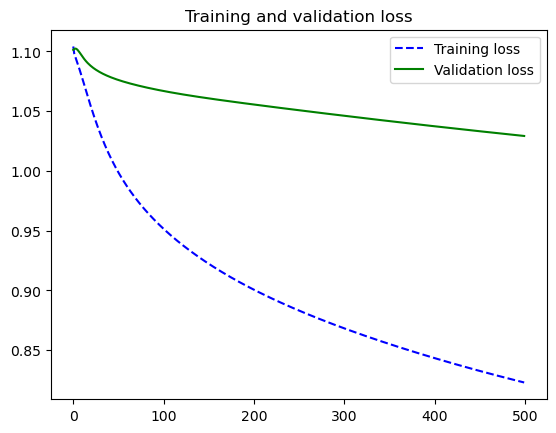

In [21]:
plt.plot(result_train_loss, 'b', linestyle="--",label='Training loss')
plt.plot(result_test_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Question 3 :** Compute the accuracy.

In [22]:
model.eval()
score_test = 0
for i in range(X_test.shape[0]):
    y_pred_test = model.forward(X_test[i])
    if torch.argmax(y_pred_test) == torch.argmax(y_test[i]):
        score_test += 1
score_train = 0
for i in range(X_train.shape[0]):
    y_pred_train = model.forward(X_train[i])
    if torch.argmax(y_pred_train) == torch.argmax(y_train[i]):
        score_train += 1
print(f"score du modèle sur le training: {score_train/X_train.shape[0]}")
print(f"score du modèle sur le test: {score_test/X_test.shape[0]}")


score du modèle sur le training: 0.8148148148148148
score du modèle sur le test: 0.5555555555555556


**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

In [129]:
import torch
### transform X with your preprocessing
pstft = STFT(idx_frequency_max=80, stats='moyenne')
X_processed = pstft.transform(X)

X_fourier = np.abs(fft(X))
X_pca = sklearn.decomposition.PCA(n_components=20)
X_pca.fit(X_fourier)
X_acp = X_pca.transform(X_fourier)

X_train, X_test, y_train, y_test = train_test_split(X_acp,y,test_size=0.5, random_state=28)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

In [130]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(20,9),
            torch.nn.ReLU(),
            torch.nn.Linear(9,3),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return self.network(xb)

In [131]:
model = NNClassification()
num_epochs = 200

result_test_loss = []
result_train_loss=[]

batch_size = 1

lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(),lr, weight_decay=2e-1)
loss = torch.nn.CrossEntropyLoss() ### Cross-entropy loss because it is a classification problem
for epoch in range(num_epochs):

    model.train()
    train_losses = []
    for i in range(int(X_train.shape[0]/batch_size)):
        # x_input = X_train[i:i+batch_size]
        # y_input = y_train[i:i+batch_size]
        optimizer.zero_grad()

        # y_pred = model.forward(x_input)
        y_pred = model.forward(X_train[i])
        # train_losses.append(loss(y_pred, y_input))
        lambda_l1 = 0.15
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss_value = loss(y_pred, y_train[i]) + lambda_l1*l1_norm
        loss_value.backward()
        train_losses.append(loss_value)

        optimizer.step()

       ### code the training step (compute loss -> optimization step -> save the loss )
        
    model.eval()
    test_losses = []
    for i in range(int(X_test.shape[0]/batch_size)):
        # x_input = X_test[i:i+batch_size]
        # y_input = y_test[i:i+batch_size]

        # y_pred = model.forward(x_input)
        # test_losses.append(loss(y_pred, y_input))
        y_pred = model.forward(X_test[i])
        loss_value = loss(y_pred, y_test[i])
        test_losses.append(loss_value)
        
        ### code the eval step  (compute loss -> save the loss )

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    



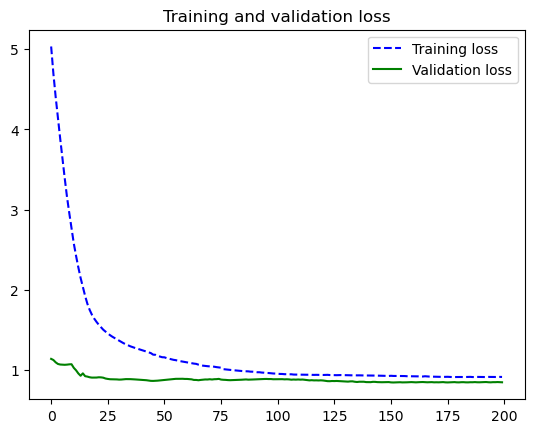

In [132]:
plt.plot(result_train_loss, 'b', linestyle="--",label='Training loss')
plt.plot(result_test_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [133]:
model.eval()
score_test = 0
for i in range(X_test.shape[0]):
    y_pred_test = model.forward(X_test[i])
    if torch.argmax(y_pred_test) == torch.argmax(y_test[i]):
        score_test += 1
score_train = 0
for i in range(X_train.shape[0]):
    y_pred_train = model.forward(X_train[i])
    if torch.argmax(y_pred_train) == torch.argmax(y_train[i]):
        score_train += 1
print(f"score du modèle sur le training: {score_train/X_train.shape[0]}")
print(f"score du modèle sur le test: {score_test/X_test.shape[0]}")


score du modèle sur le training: 0.8518518518518519
score du modèle sur le test: 0.7407407407407407


**Question 5(Bonus)** : Create a CNN that takes in input the accoustic signal without preprocessing

In [139]:
import torch

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=28)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

In [174]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.Conv1d(in_channels=16, out_channels=4, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(37032, 128),
            torch.nn.Dropout(0.25),
            torch.nn.ReLU(),
            torch.nn.Linear(128 , 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,3),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return self.network(xb)

In [177]:
model = NNClassification()
num_epochs = 50

result_test_loss = []
result_train_loss=[]

batch_size = 1

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr, weight_decay=1e-8)
loss = torch.nn.CrossEntropyLoss() ### Cross-entropy loss because it is a classification problem
for epoch in range(num_epochs):
    print(epoch)

    model.train()
    train_losses = []
    for i in range(int(X_train.shape[0]/batch_size)):
        # x_input = X_train[i:i+batch_size]
        # y_input = y_train[i:i+batch_size]
        optimizer.zero_grad()
        # y_pred = model.forward(x_input)
        y_pred = model.forward(X_train[i:i+1])
        # train_losses.append(loss(y_pred, y_input))
        lambda_l1 = 0.000015
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss_value = loss(y_pred, y_train[i])+lambda_l1*l1_norm
        loss_value.backward()
        train_losses.append(loss_value)

        optimizer.step()

       ### code the training step (compute loss -> optimization step -> save the loss )
        
    model.eval()
    test_losses = []
    for i in range(int(X_test.shape[0]/batch_size)):
        # x_input = X_test[i:i+batch_size]
        # y_input = y_test[i:i+batch_size]

        # y_pred = model.forward(x_input)
        # test_losses.append(loss(y_pred, y_input))
        y_pred = model.forward(X_test[i:i+1])
        loss_value = loss(y_pred, y_test[i])
        test_losses.append(loss_value)
        
        ### code the eval step  (compute loss -> save the loss )

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


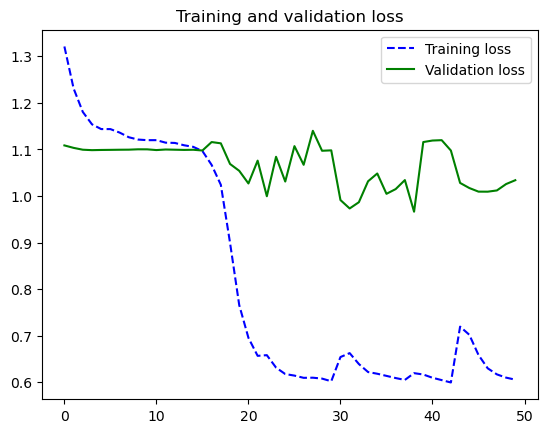

In [178]:
plt.plot(result_train_loss, 'b', linestyle="--",label='Training loss')
plt.plot(result_test_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [179]:
model.eval()
score_test = 0
for i in range(X_test.shape[0]):
    y_pred_test = model.forward(X_test[i:i+1])
    if torch.argmax(y_pred_test) == torch.argmax(y_test[i]):
        score_test += 1
score_train = 0
for i in range(X_train.shape[0]):
    y_pred_train = model.forward(X_train[i:i+1])
    if torch.argmax(y_pred_train) == torch.argmax(y_train[i]):
        score_train += 1
print(f"score du modèle sur le training: {score_train/X_train.shape[0]}")
print(f"score du modèle sur le test: {score_test/X_test.shape[0]}")


score du modèle sur le training: 1.0
score du modèle sur le test: 0.48148148148148145
